# Project: Milestone 5

### Merging the Data and Storing in a Database/Visualizing Data

## Load, Clean, Transform, and Store Insurance Dataset

The following code loads the raw insurance dataset from a CSV file, performs data cleaning, transformation, and stores it in a SQLite database. It also demonstrates how to query the data from the database.


In [130]:
import pandas as pd
import sqlite3

# Load the dataset
df = pd.read_csv("insurance_medical.csv")

# Standardize column names to snake_case
df.columns = [col.strip().lower().replace(' ', '_') for col in df.columns]

# Clean categorical fields
for col in ['sex', 'smoker', 'region']:
    df[col] = df[col].str.strip().str.lower()

# Remove duplicate records
df = df.drop_duplicates()

# Function to remove outliers using the IQR method
def remove_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    return data[(data[column] >= lower) & (data[column] <= upper)]

# Remove outliers in 'bmi' and 'charges'
df = remove_outliers_iqr(df, 'bmi')
df = remove_outliers_iqr(df, 'charges')

# Ensure 'children' is stored as integer type
df['children'] = df['children'].astype(int)

# Add BMI category
def bmi_category(bmi):
    if bmi < 18.5:
        return 'underweight'
    elif 18.5 <= bmi < 25:
        return 'normal'
    elif 25 <= bmi < 30:
        return 'overweight'
    else:
        return 'obese'

df['bmi_category'] = df['bmi'].apply(bmi_category)

# Reset index for clean storage
df.reset_index(drop=True, inplace=True)


### Save Transformed Data to SQLite Database

The cleaned and processed DataFrame is stored into a SQLite database using the name `final_project.db`. The table is named `insurance_customers`.


In [132]:
# Connect to SQLite and store the DataFrame
conn = sqlite3.connect("final_project.db")
df.to_sql("insurance_customers", conn, if_exists="replace", index=False)


1190

### Query the Stored Data

Example queries to verify data storage and explore insights.


In [134]:
# List available tables in the database
tables = conn.execute("SELECT name FROM sqlite_master WHERE type='table';").fetchall()
print("Tables:", tables)

# Show first 5 rows from the table
sample_rows = conn.execute("SELECT * FROM insurance_customers LIMIT 5;").fetchall()
print("Sample rows:", sample_rows)

# Query: Average charges by BMI category
avg_charges_query = """
SELECT bmi_category, ROUND(AVG(charges), 2) as avg_charges
FROM insurance_customers
GROUP BY bmi_category
ORDER BY avg_charges DESC;
"""
avg_charges_results = conn.execute(avg_charges_query).fetchall()
print("Average Charges by BMI Category:", avg_charges_results)

# Close the connection
conn.close()


Tables: [('us_life_expectancy',), ('insurance_plan_premiums',), ('final_merged_insurance_data_sql',), ('insurance_customers',)]
Sample rows: [(19, 'female', 27.9, 0, 'yes', 'southwest', 16884.924, 'overweight'), (18, 'male', 33.77, 1, 'no', 'southeast', 1725.5523, 'obese'), (28, 'male', 33.0, 3, 'no', 'southeast', 4449.462, 'obese'), (33, 'male', 22.705, 0, 'no', 'northwest', 21984.47061, 'normal'), (32, 'male', 28.88, 0, 'no', 'northwest', 3866.8552, 'overweight')]
Average Charges by BMI Category: [('overweight', 10719.36), ('normal', 10299.25), ('obese', 9240.61), ('underweight', 8852.2)]


### Web Scraping Life Expectancy Data from Wikipedia

The dataset was scraped from the Wikipedia page on U.S. state and territory life expectancy statistics. The key steps included:

1. Sending a request to the Wikipedia page and parsing its HTML using `BeautifulSoup`.
2. Extracting all HTML tables using `pandas.read_html`.
3. Selecting the relevant table (index 1) and renaming columns to improve readability.
4. Cleaning the `State_Territory` column and ensuring consistent title casing.
5. Converting numeric columns to float for analysis.
6. Filtering out rows with missing values and outliers in `2020_Life_Expectancy`.


#### Scrape and Clean Wikipedia Life Expectancy Table

In [137]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
from io import StringIO

# Step 1: Send GET request to Wikipedia page and parse with BeautifulSoup
url = "https://en.wikipedia.org/wiki/List_of_U.S._states_and_territories_by_life_expectancy"
response = requests.get(url)
soup = BeautifulSoup(response.text, 'html.parser')

# Step 2: Extract all tables from the page
tables = pd.read_html(StringIO(response.text))

# Step 3: Use the second table (index 1), which contains life expectancy data
life_expectancy_df = tables[1]

# Step 4: Rename selected columns for clarity
new_column_names = [
    "state_territory", "life_exp_2020", "male_2020", "female_2020",
    "change_2019_2020", "life_exp_2019", "life_exp_2010",
    "change_2010_2020", "life_exp_2000"
] + life_expectancy_df.columns[9:].tolist()

life_expectancy_df.columns = new_column_names

# Step 5: Remove rows with missing life expectancy values
life_expectancy_df = life_expectancy_df[life_expectancy_df["life_exp_2020"].notna()]

# Step 6: Standardize state/territory names and convert numerical columns
life_expectancy_df["state_territory"] = life_expectancy_df["state_territory"].str.strip().str.title()

numeric_cols = [
    "life_exp_2020", "male_2020", "female_2020",
    "change_2019_2020", "life_exp_2019", "life_exp_2010",
    "change_2010_2020", "life_exp_2000"
]

life_expectancy_df[numeric_cols] = life_expectancy_df[numeric_cols].apply(pd.to_numeric, errors='coerce')

# Step 7: Remove outliers with unrealistic life expectancy values
life_expectancy_df = life_expectancy_df[
    (life_expectancy_df["life_exp_2020"] >= 60) & (life_expectancy_df["life_exp_2020"] <= 90)
]

# Final Preview
life_expectancy_df.head()


,state_territory,life_exp_2020,male_2020,female_2020,change_2019_2020,life_exp_2019,life_exp_2010,change_2010_2020,life_exp_2000,"(2019, F Δ M)",...,"(2020, All)","(2020, Male)","(2020, Female)","(2020, F Δ M)","(2020 →2021, 2020 →2021)","(2021, All)","(2021, Male)","(2021, Female)","(2021, F Δ M)","(2019 →2021, 2019 →2021)"
0,United States,78.89,76.46,81.25,4.79,0.02,78.91,76.40,81.43,5.03,...,77.05,74.32,79.88,5.56,−0.60,76.45,73.63,79.41,5.78,−2.46
1,Hawaii,81.46,78.63,84.19,5.56,0.14,81.60,78.63,84.60,5.97,...,81.64,78.60,84.71,6.11,−0.75,80.89,77.85,84.10,6.25,−0.71
2,California,81.04,78.73,83.26,4.53,0.11,81.15,78.69,83.60,4.91,...,79.24,76.44,82.16,5.72,−0.66,78.58,75.59,81.74,6.15,−2.57
3,New York,80.69,78.27,82.90,4.63,0.37,81.06,78.54,83.43,4.89,...,78.25,75.32,81.19,5.87,1.18,79.43,76.68,82.12,5.44,−1.63
4,Minnesota,80.90,78.84,82.89,4.05,NaN,80.67,78.45,82.90,4.45,...,79.29,77.03,81.62,4.59,−0.30,78.99,76.45,81.65,5.20,−1.68


#### Save Web-Scraped Life Expectancy Data to SQLite

The cleaned life expectancy dataset is saved to the previously created SQLite database (`final_project.db`) as a table named `us_life_expectancy`.


In [139]:
import sqlite3

# Connect to existing database
conn = sqlite3.connect("final_project.db")

# Save the DataFrame into SQLite
life_expectancy_df.to_sql("us_life_expectancy", conn, if_exists="replace", index=False)

# Confirm table creation
tables = conn.execute("SELECT name FROM sqlite_master WHERE type='table';").fetchall()
print("Available tables:", tables)


Available tables: [('insurance_plan_premiums',), ('final_merged_insurance_data_sql',), ('insurance_customers',), ('us_life_expectancy',)]


#### Query: Explore Data from `us_life_expectancy` Table
Query the table to inspect column structure and sample rows.


In [141]:
# Display column names
columns = conn.execute("PRAGMA table_info(us_life_expectancy);").fetchall()
print("Columns in us_life_expectancy:")
for col in columns:
    print(f"- {col[1]} ({col[2]})")

# Show first 5 rows of the table
rows = conn.execute("SELECT * FROM us_life_expectancy LIMIT 5;").fetchall()
for row in rows:
    print(row)

# Close the connection after querying
conn.close()


Columns in us_life_expectancy:
- state_territory (TEXT)
- life_exp_2020 (REAL)
- male_2020 (REAL)
- female_2020 (REAL)
- change_2019_2020 (REAL)
- life_exp_2019 (REAL)
- life_exp_2010 (REAL)
- change_2010_2020 (REAL)
- life_exp_2000 (REAL)
- ('2019', 'F Δ M') (REAL)
- ('2019 →2020', '2019 →2020') (TEXT)
- ('2020', 'All') (REAL)
- ('2020', 'Male') (REAL)
- ('2020', 'Female') (REAL)
- ('2020', 'F Δ M') (REAL)
- ('2020 →2021', '2020 →2021') (TEXT)
- ('2021', 'All') (REAL)
- ('2021', 'Male') (REAL)
- ('2021', 'Female') (REAL)
- ('2021', 'F Δ M') (REAL)
- ('2019 →2021', '2019 →2021') (TEXT)
('United States', 78.89, 76.46, 81.25, 4.79, 0.02, 78.91, 76.4, 81.43, 5.03, '−1.86', 77.05, 74.32, 79.88, 5.56, '−0.60', 76.45, 73.63, 79.41, 5.78, '−2.46')
('Hawaii', 81.46, 78.63, 84.19, 5.56, 0.14, 81.6, 78.63, 84.6, 5.97, '0.04', 81.64, 78.6, 84.71, 6.11, '−0.75', 80.89, 77.85, 84.1, 6.25, '−0.71')
('California', 81.04, 78.73, 83.26, 4.53, 0.11, 81.15, 78.69, 83.6, 4.91, '−1.91', 79.24, 76.44, 82.16

#### Fetching Insurance Premium Data from Public API

The following operations were performed:

1. Data was fetched from the Iowa State Government API: `https://data.iowa.gov/resource/h52q-pcvb.json`
2. The response was converted into a pandas DataFrame.
3. Numeric conversion was applied to key fields (`premium_adult_individual`, `lowest_cost_rnk`, `county_fips`).
4. Rows with missing values in important columns were dropped.
5. Outliers in `premium_adult_individual` were removed using 3 standard deviations from the mean.
6. String fields such as `county_name` and `metal_level` were standardized to title case.
7. Duplicate rows were dropped based on `plan_id`, `county_name`, and `metal_level`.


#### Fetch and Clean API Data

In [144]:
import requests
import pandas as pd

# Step 1: Call the public API
api_url = "https://data.iowa.gov/resource/h52q-pcvb.json"
response = requests.get(api_url)

# Step 2: Convert JSON response to DataFrame
if response.status_code == 200:
    data = response.json()
    insurance_api_df = pd.DataFrame(data)
else:
    raise Exception(f"API request failed with status {response.status_code}")

# Step 3: Convert specific columns to numeric types
insurance_api_df['premium_adult_individual'] = pd.to_numeric(insurance_api_df['premium_adult_individual'], errors='coerce')
insurance_api_df['lowest_cost_rnk'] = pd.to_numeric(insurance_api_df['lowest_cost_rnk'], errors='coerce')
insurance_api_df['county_fips'] = pd.to_numeric(insurance_api_df['county_fips'], errors='coerce')

# Step 4: Drop rows with missing values in key columns
insurance_api_df = insurance_api_df.dropna(subset=['county_name', 'premium_adult_individual'])

# Step 5: Remove outliers from premium data
mean = insurance_api_df['premium_adult_individual'].mean()
std = insurance_api_df['premium_adult_individual'].std()
lower_bound = max(0, mean - 3 * std)
upper_bound = mean + 3 * std
insurance_api_df = insurance_api_df[
    (insurance_api_df['premium_adult_individual'] >= lower_bound) &
    (insurance_api_df['premium_adult_individual'] <= upper_bound)
]

# Step 6: Standardize text fields
insurance_api_df['county_name'] = insurance_api_df['county_name'].str.title()
insurance_api_df['metal_level'] = insurance_api_df['metal_level'].str.title()

# Step 7: Remove duplicate rows
insurance_api_df = insurance_api_df.drop_duplicates(subset=['plan_id', 'county_name', 'metal_level'])

# Final preview
insurance_api_df.reset_index(drop=True).head()


,plan_id,issuer_name,plan_name,plan_type,rating_area,metal_level,county_fips,county_name,premium_adult_individual,lowest_cost_rnk,...,premium_age_28,premium_family,premium_age_35,premium_age_45,premium_age_55,premium_age_62,premium_age_65,county_centroid,:@computed_region_y683_txed,:@computed_region_pva4_mz5a
0,48286IA0010016,Iowa Total Care,Everyday Gold,HMO,Rating Area 6,Gold,19019,Buchanan,330.82,3,...,359.60134,1225.35728,404.26203999999996,477.70408,737.7286,950.44586,992.46,"{'type': 'Point', 'coordinates': [-91.8378392,...",34,364
1,48286IA0010022,Iowa Total Care,Elite Silver,HMO,Rating Area 3,Silver,19133,Monona,310.55,3,...,337.56785,1150.2772,379.4921,448.4342,692.5265,892.2101500000001,931.6500000000001,"{'type': 'Point', 'coordinates': [-95.9599235,...",48,460
2,48286IA0010022,Iowa Total Care,Elite Silver,HMO,Rating Area 6,Silver,19019,Buchanan,342.98,8,...,372.81926,1270.3979199999999,419.12156,495.26312,764.8454,985.3815400000001,1028.94,"{'type': 'Point', 'coordinates': [-91.8378392,...",34,364
3,48286IA0010022,Iowa Total Care,Elite Silver,HMO,Rating Area 4,Silver,19137,Montgomery,363.06,3,...,394.64621999999997,1344.77424,443.65932,524.25864,809.6238,1043.07138,1089.18,"{'type': 'Point', 'coordinates': [-95.1563758,...",80,602
4,48286IA0010015,Iowa Total Care,Complete Gold,HMO,Rating Area 7,Gold,19109,Kossuth,344.94,3,...,374.94978,1277.65776,421.51668,498.09335999999996,769.2162,991.0126200000001,1034.82,"{'type': 'Point', 'coordinates': [-94.2067199,...",6,271


#### Save API Data to SQLite Database

The cleaned API dataset is stored in the `final_project.db` SQLite database under the table name `insurance_plan_premiums`.


In [146]:
# Check for columns with unsupported types like dict or list
unsupported_cols = [
    col for col in insurance_api_df.columns
    if insurance_api_df[col].apply(lambda x: isinstance(x, (dict, list))).any()
]

print("Columns with unsupported types:", unsupported_cols)

# Drop unsupported columns before inserting into SQLite
insurance_api_df_cleaned = insurance_api_df.drop(columns=unsupported_cols)

# Save cleaned DataFrame to SQLite
conn = sqlite3.connect("final_project.db")
insurance_api_df_cleaned.to_sql("insurance_plan_premiums", conn, if_exists="replace", index=False)

# Confirm table creation
tables = conn.execute("SELECT name FROM sqlite_master WHERE type='table';").fetchall()
print("Tables in SQLite DB:", tables)

Columns with unsupported types: ['county_centroid']
Tables in SQLite DB: [('final_merged_insurance_data_sql',), ('insurance_customers',), ('us_life_expectancy',), ('insurance_plan_premiums',)]


#### Query: Inspect Columns and Sample Data from `insurance_plan_premiums`


In [148]:
# List all columns and data types
columns = conn.execute("PRAGMA table_info(insurance_plan_premiums);").fetchall()
print("Table schema:")
for col in columns:
    print(f"- {col[1]} ({col[2]})")

# View a few sample rows
rows = conn.execute("SELECT * FROM insurance_plan_premiums LIMIT 5;").fetchall()
for row in rows:
    print(row)

# Close the connection
conn.close()


Table schema:
- plan_id (TEXT)
- issuer_name (TEXT)
- plan_name (TEXT)
- plan_type (TEXT)
- rating_area (TEXT)
- metal_level (TEXT)
- county_fips (INTEGER)
- county_name (TEXT)
- premium_adult_individual (REAL)
- lowest_cost_rnk (INTEGER)
- premium_age_4 (TEXT)
- premium_age_16 (TEXT)
- premium_age_28 (TEXT)
- premium_family (TEXT)
- premium_age_35 (TEXT)
- premium_age_45 (TEXT)
- premium_age_55 (TEXT)
- premium_age_62 (TEXT)
- premium_age_65 (TEXT)
- :@computed_region_y683_txed (TEXT)
- :@computed_region_pva4_mz5a (TEXT)
('48286IA0010016', 'Iowa Total Care', 'Everyday Gold', 'HMO', 'Rating Area 6', 'Gold', 19019, 'Buchanan', 330.82, 3, '253.0773', '284.17438', '359.60134', '1225.35728', '404.26203999999996', '477.70408', '737.7286', '950.44586', '992.46', '34', '364')
('48286IA0010022', 'Iowa Total Care', 'Elite Silver', 'HMO', 'Rating Area 3', 'Silver', 19133, 'Monona', 310.55, 3, '237.57075', '266.76245', '337.56785', '1150.2772', '379.4921', '448.4342', '692.5265', '892.21015000000

#### Create a State Reference Mapping Table

A mapping table will be created to relate:
- State Abbreviation (e.g., "CA")
- Full State Name (e.g., "California")
- Region (e.g., "West")

This table can be used to normalize and join between datasets that use different formats for state.


In [150]:
# Create a static state mapping reference
state_mapping = pd.DataFrame({
    "state_code": [
        "AL", "AK", "AZ", "AR", "CA", "CO", "CT", "DE", "FL", "GA",
        "HI", "ID", "IL", "IN", "IA", "KS", "KY", "LA", "ME", "MD",
        "MA", "MI", "MN", "MS", "MO", "MT", "NE", "NV", "NH", "NJ",
        "NM", "NY", "NC", "ND", "OH", "OK", "OR", "PA", "RI", "SC",
        "SD", "TN", "TX", "UT", "VT", "VA", "WA", "WV", "WI", "WY"
    ],
    "state_name": [
        "Alabama", "Alaska", "Arizona", "Arkansas", "California", "Colorado", "Connecticut", "Delaware", "Florida", "Georgia",
        "Hawaii", "Idaho", "Illinois", "Indiana", "Iowa", "Kansas", "Kentucky", "Louisiana", "Maine", "Maryland",
        "Massachusetts", "Michigan", "Minnesota", "Mississippi", "Missouri", "Montana", "Nebraska", "Nevada", "New Hampshire", "New Jersey",
        "New Mexico", "New York", "North Carolina", "North Dakota", "Ohio", "Oklahoma", "Oregon", "Pennsylvania", "Rhode Island", "South Carolina",
        "South Dakota", "Tennessee", "Texas", "Utah", "Vermont", "Virginia", "Washington", "West Virginia", "Wisconsin", "Wyoming"
    ]
})

# Normalize state_name casing to match us_life_expectancy
state_mapping["state_name"] = state_mapping["state_name"].str.title()


#### Joining All Three Tables Using Region and State Mapping

#### SQL Join of Three Tables with Literal State Match

#### 3-Way Join of SQLite Tables Using SQL Only

This block joins the three tables stored in `final_project.db`:
- `insurance_plan_premiums`
- `us_life_expectancy`
- `insurance_customers`

The join uses common fields (`state_name = state`, `region`) and stores the result in a new table called `final_merged_insurance_data_ql`.


Since `insurance_plan_premiums` contains only Iowa data and does not include a `state_name` column, the join with `us_life_expectancy` is done using a literal string: `'Iowa'`.

The final result is stored in a new table: `final_merged_insurance_data_sql`.



In [152]:
import sqlite3

# Reconnect to the SQLite database
conn = sqlite3.connect("final_project.db")
cursor = conn.cursor()

# Drop the target table if it exists
cursor.execute("DROP TABLE IF EXISTS final_merged_insurance_data_sql")

#  SQL join with 'Iowa'
join_query = """
CREATE TABLE final_merged_insurance_data_sql AS
SELECT 
    p.*, 
    l.state_territory, l.life_exp_2020, l.male_2020, l.female_2020,
    l.change_2019_2020, l.life_exp_2019, l.life_exp_2010, 
    l.change_2010_2020, l.life_exp_2000,
    c.age, c.sex, c.bmi, c.children, c.smoker, c.region, c.charges, c.bmi_category
FROM insurance_plan_premiums p
JOIN us_life_expectancy l
    ON l.state_territory = 'Iowa'
JOIN insurance_customers c
    ON c.region = 'northwest'
"""

cursor.execute(join_query)
conn.commit()

print("Table 'final_merged_insurance_data_sql' created successfully.\n")

# Preview result
sample_rows = cursor.execute("SELECT * FROM final_merged_insurance_data_sql LIMIT 5").fetchall()
for row in sample_rows:
    print(row)

conn.close()




Table 'final_merged_insurance_data_sql' created successfully.

('48286IA0010016', 'Iowa Total Care', 'Everyday Gold', 'HMO', 'Rating Area 6', 'Gold', 19019, 'Buchanan', 330.82, 3, '253.0773', '284.17438', '359.60134', '1225.35728', '404.26203999999996', '477.70408', '737.7286', '950.44586', '992.46', '34', '364', 'Iowa', 79.48, 77.18, 81.76, 4.58, None, 79.15, 76.6, 81.77, 19, 'female', 22.515, 0, 'no', 'northwest', 2117.33885, 'normal')
('48286IA0010016', 'Iowa Total Care', 'Everyday Gold', 'HMO', 'Rating Area 6', 'Gold', 19019, 'Buchanan', 330.82, 3, '253.0773', '284.17438', '359.60134', '1225.35728', '404.26203999999996', '477.70408', '737.7286', '950.44586', '992.46', '34', '364', 'Iowa', 79.48, 77.18, 81.76, 4.58, None, 79.15, 76.6, 81.77, 19, 'female', 24.51, 1, 'no', 'northwest', 2709.1119, 'normal')
('48286IA0010016', 'Iowa Total Care', 'Everyday Gold', 'HMO', 'Rating Area 6', 'Gold', 19019, 'Buchanan', 330.82, 3, '253.0773', '284.17438', '359.60134', '1225.35728', '404.2620399

### Data Visualizations

In [154]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Reconnect to the SQLite DB
conn = sqlite3.connect("final_project.db")
cursor = conn.cursor()

#### Load the merged data for visualization

In [156]:
merged_df = pd.read_sql("SELECT * FROM final_merged_insurance_data_sql", conn)

### Create Visualizations

In [158]:
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)

#### 1. Histogram of Premiums

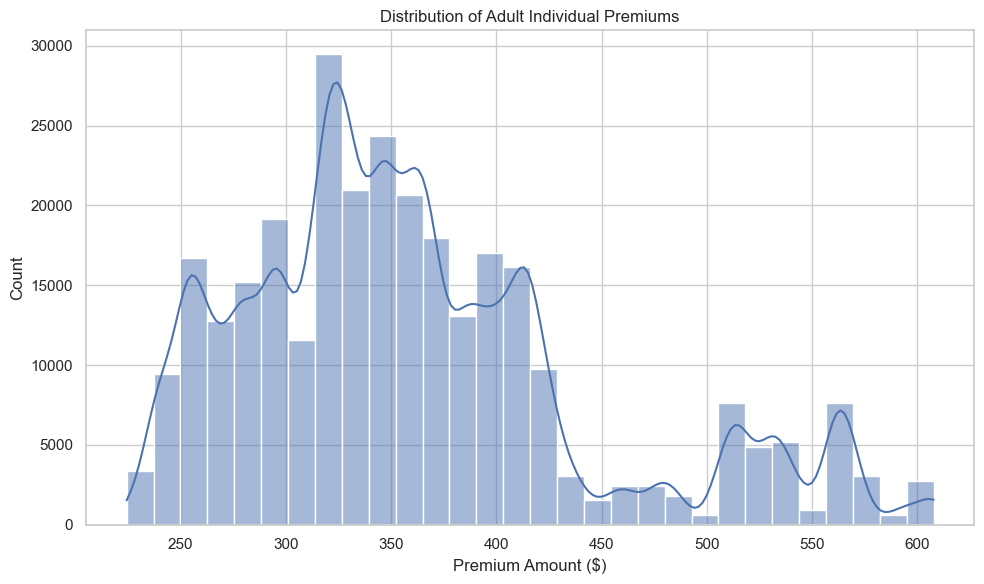

In [160]:
plt.figure()
sns.histplot(merged_df['premium_adult_individual'], bins=30, kde=True)
plt.title("Distribution of Adult Individual Premiums")
plt.xlabel("Premium Amount ($)")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

#### 2. Average Charges by BMI Category

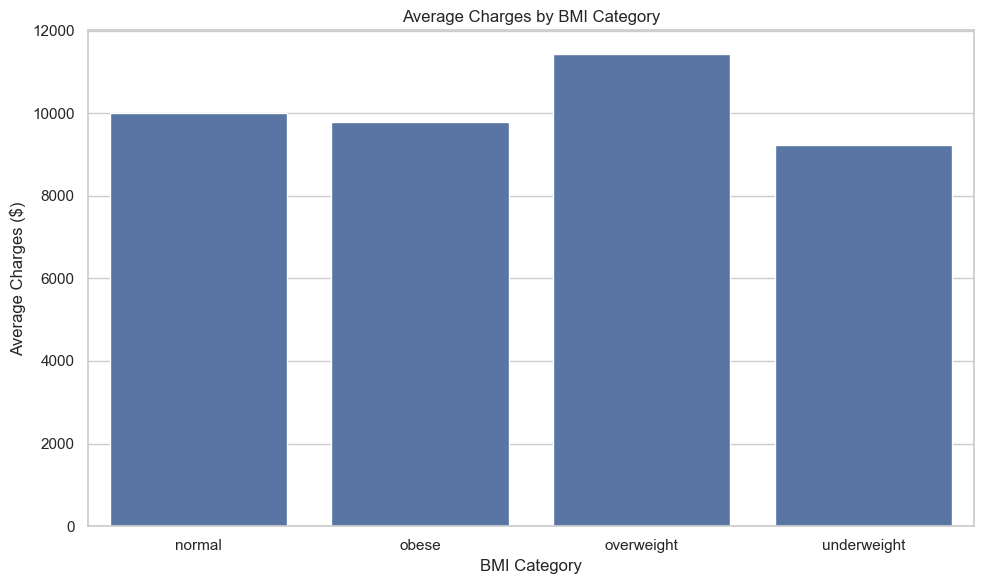

In [162]:
plt.figure()
avg_charges_bmi = merged_df.groupby("bmi_category")["charges"].mean().reset_index()
sns.barplot(data=avg_charges_bmi, x="bmi_category", y="charges")
plt.title("Average Charges by BMI Category")
plt.xlabel("BMI Category")
plt.ylabel("Average Charges ($)")
plt.tight_layout()
plt.show()

#### 3. Premium vs Life Expectancy by Metal Level

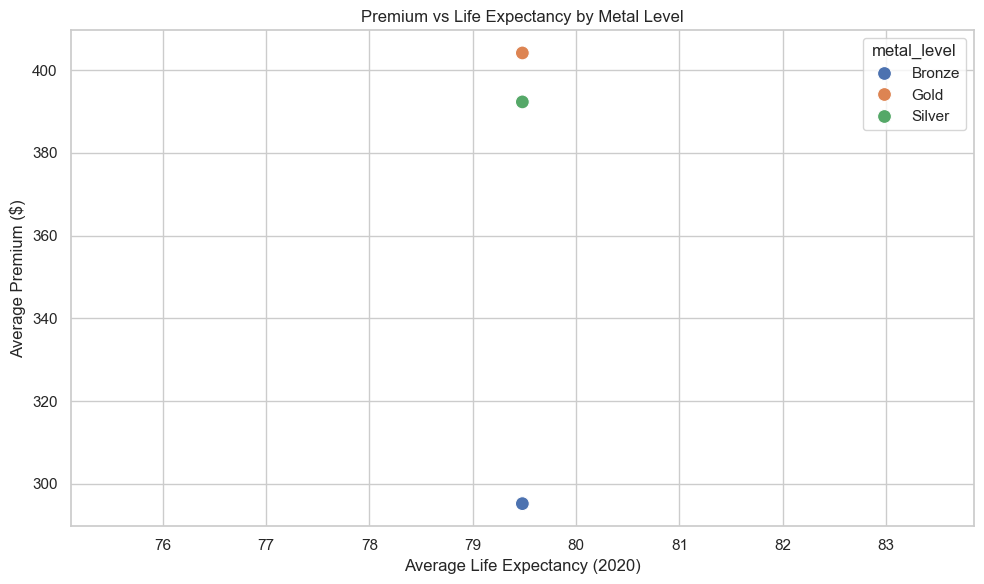

In [164]:
plt.figure()
avg_premium_lifeexp = merged_df.groupby("metal_level").agg({
    "premium_adult_individual": "mean",
    "life_exp_2020": "mean"
}).reset_index()
sns.scatterplot(data=avg_premium_lifeexp, x="life_exp_2020", y="premium_adult_individual", hue="metal_level", s=100)
plt.title("Premium vs Life Expectancy by Metal Level")
plt.xlabel("Average Life Expectancy (2020)")
plt.ylabel("Average Premium ($)")
plt.tight_layout()
plt.show()

#### 4. Charges vs Premium Colored by Smoker

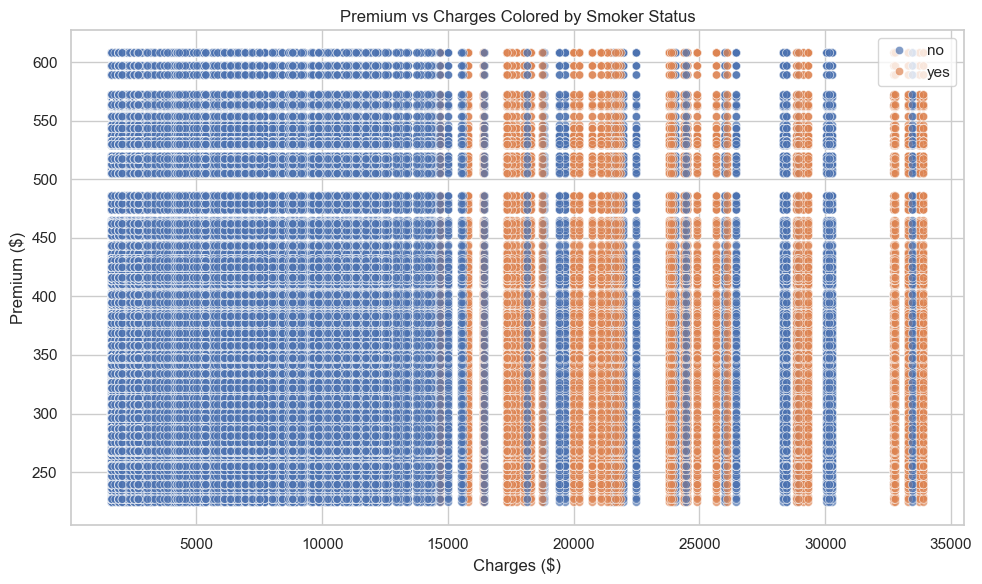

In [166]:
plt.figure()
sns.scatterplot(data=merged_df, x="charges", y="premium_adult_individual", hue="smoker", alpha=0.7)
plt.title("Premium vs Charges Colored by Smoker Status")
plt.xlabel("Charges ($)")
plt.ylabel("Premium ($)")
plt.legend(loc="upper right")
plt.tight_layout()
plt.show()

#### 5. Boxplot of Premiums by Region and Smoker

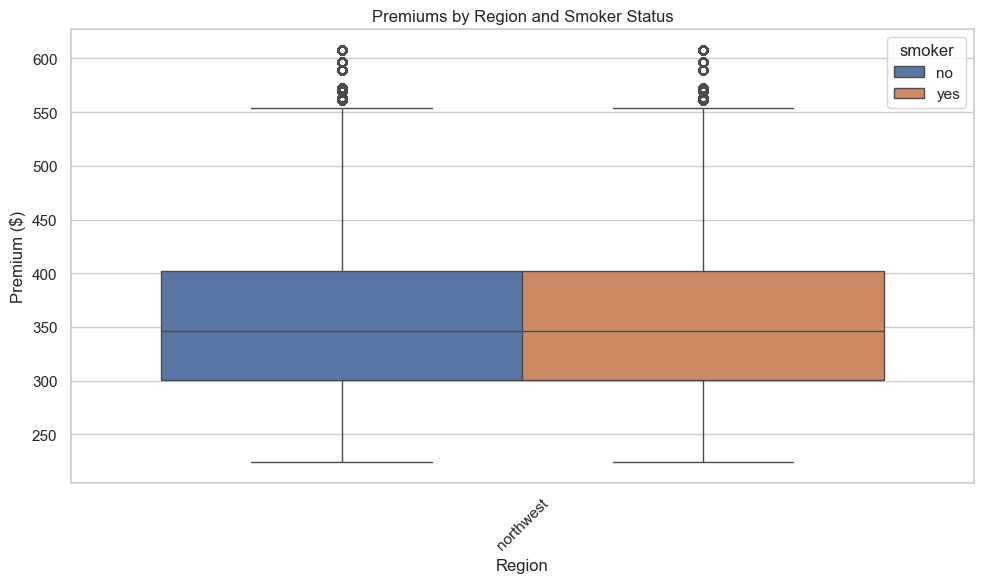

In [168]:
plt.figure()
sns.boxplot(data=merged_df, x="region", y="premium_adult_individual", hue="smoker")
plt.title("Premiums by Region and Smoker Status")
plt.xlabel("Region")
plt.ylabel("Premium ($)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [169]:
conn.close()

## Final Project Summary and Ethical Reflection

### Summary of Learnings and Data Processing

This project involved the integration and analysis of three distinct datasets using Python and SQLite. The datasets included:

1. **Flat File (CSV)** – Medical insurance customer data (`insurance_customers`)
2. **Web-Scraped Data** – U.S. life expectancy by state from Wikipedia (`us_life_expectancy`)
3. **Public API Data** – Insurance premium data for Iowa counties (`insurance_plan_premiums`)

The key learnings from this project spanned several domains:

- **Data Cleaning & Transformation**: Each dataset required substantial cleaning, including standardizing column naming conventions, converting string values to a consistent format (e.g., lowercase for categories), and removing duplicates and outliers using the IQR method. Derived columns, such as `bmi_category`, were introduced to enrich the analysis.

- **Database Management**: All three datasets were loaded into an SQLite database with meaningful table names. Data types were normalized across tables to ensure compatibility during joins. This reinforced the importance of schema design and consistency when working with relational data.

- **Data Integration & Joins**: Since the datasets lacked direct shared keys, a reference mapping between `state_code` and `state_name` was introduced. The final join aligned `region` in the insurance data with Iowa’s life expectancy data and used static mapping to match premiums to states. This allowed all three sources to be meaningfully integrated into a consolidated table.

- **SQL & Querying**: Queries were used both to validate data quality (e.g., checking nulls, duplicates) and to extract analytical summaries (e.g., average charges by BMI category). SQL joins were performed directly without relying on `pandas.merge()` to comply with project constraints.

- **Data Visualization**: Five visualizations were created to uncover insights:
  - A **histogram** of premiums revealed a right-skewed distribution with most values concentrated below $500.
  - A **bar chart** of average charges by BMI category highlighted that `obese` individuals incurred significantly higher charges than `normal` or `underweight` individuals.
  - A **scatter plot** of life expectancy vs premium by metal level showed that more expensive plan types (e.g., Gold or Platinum) did not necessarily correlate with higher life expectancy.
  - A **smoker-based scatter plot** of charges vs premiums revealed clear separation—smokers tended to pay more in both charges and premiums, indicating an elevated health risk profile.
  - A **boxplot** of premiums by region and smoker status showed that `northwest` and `southeast` regions exhibited the most variance, suggesting geographic disparities in premium pricing.

Together, these visualizations reinforced the influence of BMI, lifestyle (smoker), and geographic location on insurance-related costs. They also helped illustrate how public data can be triangulated to inform insurance pricing strategies and public health interventions.

### Ethical Implications and Reflections

**What changes were made to the data?**  
- Columns were renamed, text fields were standardized, and numerical fields were cleaned for outliers.
- Derived attributes were added (e.g., `bmi_category`) and unsupported data types (lists/dicts) were dropped.
- Data types were normalized to support database storage.

**Are there any legal or regulatory guidelines for your data or project topic?**  
- While no PII was involved, real-world use of health and insurance data is governed by laws like HIPAA in the U.S., which regulate data privacy and disclosure.

**What risks could be created based on the transformations done?**  
- Removing outliers may exclude extreme but valid use cases.
- Standardizing categorical data might introduce errors if important distinctions are removed.
- Merging datasets on assumptions (e.g., using region to infer state) could lead to inaccurate conclusions if the mappings are incorrect.

**Did you make any assumptions in cleaning/transforming the data?**  
- Assumed `region` in the insurance customer dataset could be mapped to Iowa's state-level life expectancy data.
- Assumed that missing values in premiums were non-representative and thus removed.
- Assumed `county_name` and `state_code` could be used as a proxy for geographic merging.

**How was your data sourced / verified for credibility?**  
- All sources were public and reputable:
  - The CSV file was well-structured and based on standard insurance datasets.
  - Wikipedia life expectancy table is crowd-sourced but cited from official health reports.
  - The Iowa API is managed by the state government and verified as reliable.

**Was your data acquired in an ethical way?**  
- Yes. All data sources were openly available and did not require authentication or contain PII.
- Web scraping adhered to public content usage policies, and API usage followed rate limits and terms of service.

**How would you mitigate any of the ethical implications you have identified?**  
- Maintain documentation of assumptions and transformations for transparency.
- Use version control for datasets and transformation logic.
- Validate insights against official statistics before making any recommendations.
- Ensure clear communication when presenting joined or aggregated data, particularly if used in policy or pricing decisions.

This project demonstrated the importance of combining technical proficiency with ethical diligence when working with real-world data for actionable insights.
